# Emulator evaluation

This notebook evaluates the AMSR2 simulator model on the test dataset.

In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from pytorch_retrieve.architectures import load_model
model = load_model("../models/amsr2/amsr2_emulator_2.pt").eval()

In [34]:
from poem.emulator import TrainingData
test_dataset = TrainingData("/home/simon/data/poem/test_data.nc", batch_size=2024)

In [35]:
import torch
from tqdm import tqdm

results = {}
model = model.to(device="cuda")
for batch_ind in tqdm(range(len(test_dataset))):
    x, y = test_dataset[batch_ind]
    x = x.to(device="cuda", dtype=torch.float32)
    channels = torch.argmax(x[:, -10:], -1).cpu().numpy()
    with torch.no_grad():
        y_pred = model(x)["tbs"].expected_value().float().cpu().numpy()[:, 0]
        y = y.cpu().numpy()
        mask = np.isfinite(y_pred) * np.isfinite(y)
        results.setdefault("target", []).append(y[mask])
        results.setdefault("predicted", []).append(y_pred[mask])
        results.setdefault("channels", []).append(channels[mask])

results = xr.Dataset({
    "target": (("samples"), np.concatenate(results["target"])),
    "predicted": (("samples"), np.concatenate(results["predicted"])),
    "channel": (("samples"), np.concatenate(results["channels"])),
})
    


100%|████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 326.80it/s]


## Scatter plots

In [36]:
density = np.zeros((10, 100, 100))
bins = np.zeros((10, 101))
bias = np.zeros(10)
mse = np.zeros(10)
corr = np.zeros(10)

for channel in range(10):
    mask = results.channel == channel
    res = results[{"samples": mask}]

    x_min = min(res.predicted.data.min(), res.target.data.min())
    x_max = max(res.predicted.data.max(), res.target.data.max())
    chan_bins = np.linspace(x_min, x_max, 101)
    density[channel] = np.histogram2d(res.target.data, res.predicted.data, bins=chan_bins)[0]
    bins[channel] = chan_bins

    targ = res.target.data
    pred = res.predicted.data
    bias[channel] = 100.0 * (pred - targ).mean() / targ.mean()
    mse[channel] = np.mean((pred - targ) ** 2)
    corr[channel] = np.corrcoef(pred, targ)[0, 1]
    



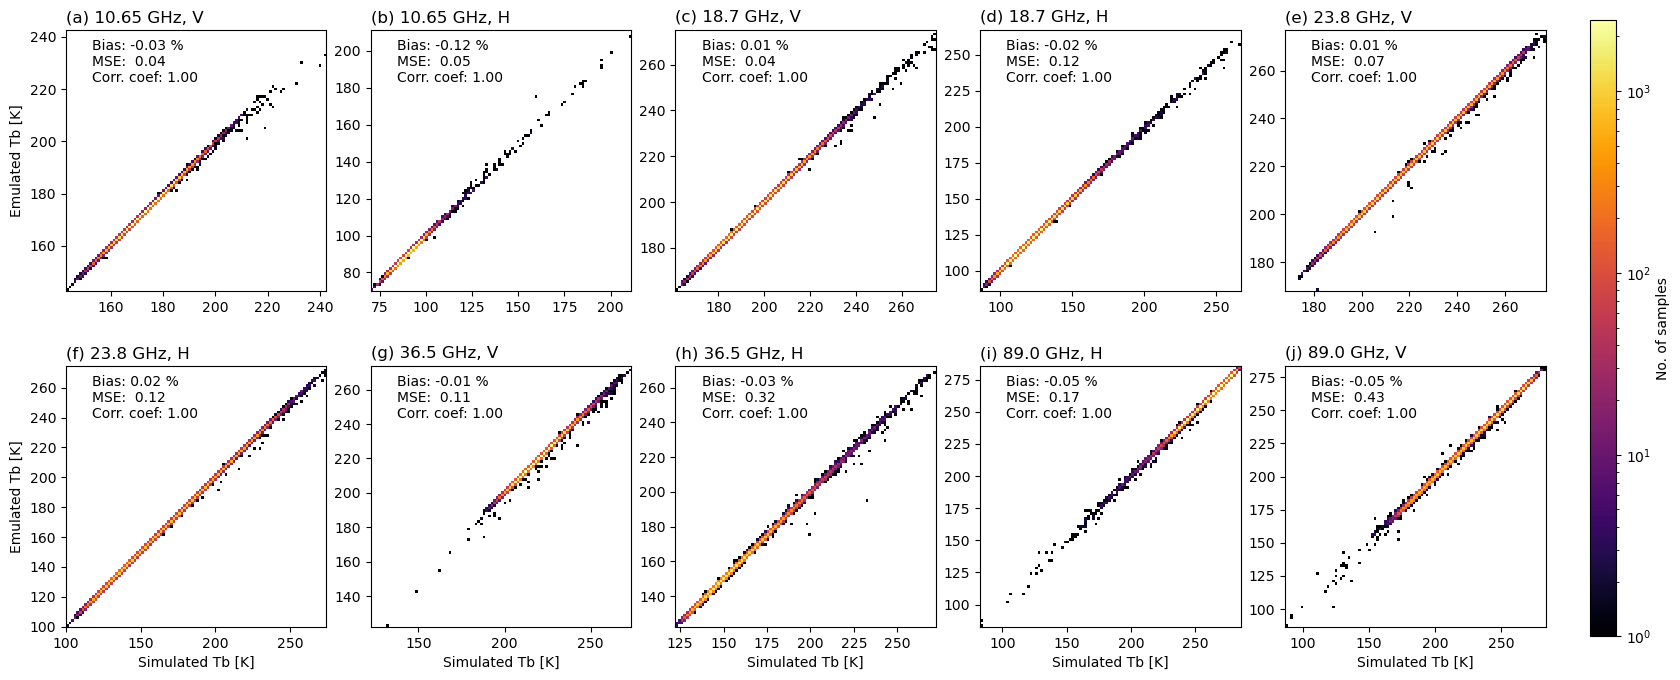

In [37]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 6, width_ratios=[1.0, 1.0, 1.0, 1.0, 1.0, 0.1])
norm = LogNorm()
cmap = "inferno"

CHAN_NAMES = [
    "10.65 GHz, V",
    "10.65 GHz, H",
    "18.7 GHz, V",
    "18.7 GHz, H",
    "23.8 GHz, V",
    "23.8 GHz, H",
    "36.5 GHz, V",
    "36.5 GHz, H",
    "89.0 GHz, H",
    "89.0 GHz, V",
]

channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for ind, chan in enumerate(channels):
    ax = fig.add_subplot(gs[ind // 5, ind % 5])
    ax.set_aspect(1.0)
    x = bins[chan]
    x = 0.5 * (x[1:] + x[:-1])
    m = ax.pcolormesh(x, x, density[chan].T, norm=norm, cmap="inferno")
    ax.set_title(f"({chr(ord('a') + ind)}) {CHAN_NAMES[chan]}", loc="left")

    if ind % 5 == 0:
        ax.set_ylabel("Emulated Tb [K]")
    if ind // 5 == 1:
        ax.set_xlabel("Simulated Tb [K]")

    stats = f"Bias: {bias[chan]:.2f} %\nMSE:  {mse[chan]:.2f}\nCorr. coef: {corr[chan]:.2f}"
    ax.text(bins[chan, 10], bins[chan, 80], stats)


ax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="No. of samples")


## Retrieval test

In [94]:
stats = xr.load_dataset("../models/amsr2/stats/input/input.nc")
x_a = torch.tensor(stats["mean"].data).to(dtype=torch.float32, device="cuda")
std_dev = torch.tensor(stats["std_dev"].data).to(dtype=torch.float32, device="cuda")
mask = np.isnan(std_dev.cpu().numpy())
std_dev[mask] = 1e-6
cov = stats["cov"].data
cov[mask, mask] = 1e-6

s_x = torch.tensor(np.linalg.inv(cov)).to(dtype=torch.float32, device="cuda")

In [95]:
def forward_model(emulator, profile):
    n_obs = profile.shape[0]
    profile = torch.repeat_interleave(profile,  torch.tensor(10, device=profile.device), 0)
    chan_1 = profile[0, 152].item()
    chan_0 = profile[0, 153].item()
    for ind in range(10):
        profile[ind, 152: 162] = chan_0
        profile[ind, 152 + ind] = chan_1
    tbs = emulator(profile.to(device="cuda"))["tbs"].expected_value().reshape(n_obs, 10)
    return tbs

In [96]:
score_model = load_model("../models/amsr2/score/amsr2_score_model.pt").to(device="cuda")

In [97]:
from copy import deepcopy
from torch import nn
model_nn = deepcopy(model)
model_nn.stems["input"][0] = nn.Identity()
nlayer = model.stems["input"][0]

In [98]:
forward_model(model, x[:3])

tensor([[154.0739, 154.0739, 154.0739, 154.0739, 154.0739, 154.0739, 154.0739,
         154.0739, 154.0739, 154.0739],
        [241.4389, 241.4389, 241.4389, 241.4389, 241.4389, 241.4389, 241.4389,
         241.4389, 241.4389, 241.4389],
        [209.6504, 209.6504, 209.6504, 209.6504, 209.6504, 209.6504, 209.6504,
         209.6504, 209.6504, 209.6504]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [99]:
y_pred = model(x[:8].to(device="cuda"))["tbs"].expected_value()
print(y_pred)
y_pred = model(profile_true.to(device="cuda"))["tbs"].expected_value()
print(y_pred)

tensor([[232.4140],
        [241.4389],
        [209.6504],
        [224.3072],
        [160.2050],
        [231.9668],
        [150.0648],
        [199.4368]], device='cuda:0', grad_fn=<DivBackward1>)
tensor([[186.0803]], device='cuda:0', grad_fn=<DivBackward1>)


In [135]:
model = model.to(device="cuda")
x, y = test_dataset[5]
profile_true = torch.clone(x[:1])
profile_true[:, 152] = 1.0
profile_true[:, 153:] = 0.0
print(profile_true[:8, 152:])
with torch.no_grad():
    y_true = forward_model(model, profile_true).detach()
    y_true_n = forward_model(model_nn.to(device="cuda"), nlayer(profile_true)).detach()

profile_mod = torch.clone(profile_true)
profile_mod[0, 0 * 36 : 1 * 36] *= 0.8
with torch.no_grad():
    y_mod = forward_model(model, profile_mod)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


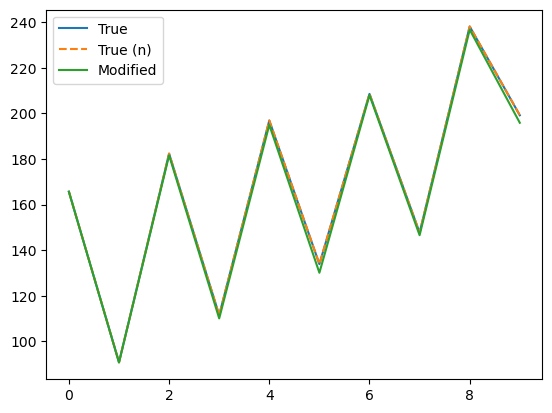

In [137]:
plt.plot(y_true[0].cpu().numpy(), label="True")
plt.plot(y_true_n[0].cpu().numpy(), label="True (n)", ls="--")
plt.plot(y_mod[0].cpu().numpy(), label="Modified")
plt.legend()

In [781]:
model = model.to(device="cuda")

In [823]:
y_true.shape

torch.Size([1, 10])

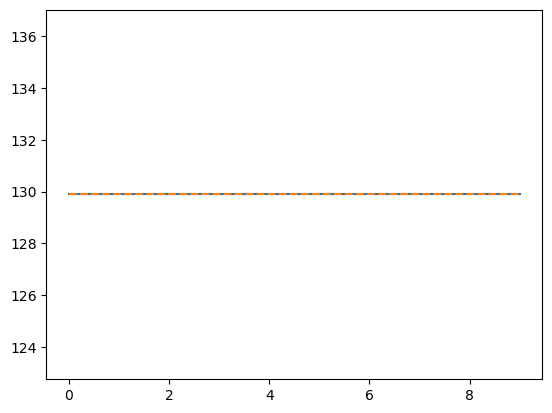

In [15]:
plt.plot(y_true[0].cpu().numpy(), c="C0")
plt.plot(y_true_n[0].cpu().numpy(), ls="--", c="C1")
#plt.plot(y_mod[0].cpu().numpy(), c="C1")

## OEM formulation


$L(y, x) = (f(x) - y)^T \mathbf{S}_e^{-1} (f(x) - y)$

In [148]:
x_0 = torch.clone(x_a[None]).detach().to(device="cuda")
x_0[0, 152] = 1.0
x_0[0, 153:] = 0.0
x_n = nlayer(x_0)
x_n.requires_grad = True
with torch.no_grad():
    y_a = forward_model(model_nn, x_n)

lr = 1e-5
for ind in range(10_000):
    if x_n.grad is not None:
        x_n.grad.zero_()
    y_step = forward_model(model_nn, x_n)
    loss_obs = ((y_step - y_true) ** 2).sum() 
    loss_score =  ((score_model(x_n[:, :147])["tbs"] - x_n[:, :147]) ** 2).mean()
    loss = loss_obs +  1e6 * loss_score
    loss.backward()
    
    d_x = x_n.grad
    d_x[torch.isnan(d_x)] = 0.0
    x_n.data[0, :147] -= lr * d_x[0, :147]
    if ind % 100 == 0:
        print(loss_obs.item(), loss_score.item())
    if ind % 10000 == 0:
        lr /= 2
  

4946.552734375 6.41955339233391e-05
388.0425720214844 3.4273878554813564e-05
153.86761474609375 3.1050767574924976e-05
93.46923065185547 2.382482671237085e-05
65.87007141113281 1.7803817172534764e-05
48.883056640625 1.3730373211728875e-05
37.82355499267578 1.106080617319094e-05
30.487167358398438 9.110702194448095e-06
25.50701904296875 7.5439511419972405e-06
22.03133773803711 6.294005288509652e-06
19.528472900390625 5.297990810504416e-06
17.65021324157715 4.525729309534654e-06
16.18517303466797 3.934394953830633e-06
14.986705780029297 3.506198254399351e-06
14.0167236328125 3.1542274427920347e-06
13.198945045471191 2.878025952668395e-06
12.50096321105957 2.6588281798467506e-06
11.899837493896484 2.4842345283104805e-06
11.378735542297363 2.3447685180144617e-06
10.924089431762695 2.233668283224688e-06
10.525336265563965 2.14634565054439e-06
10.17402458190918 2.0781915281986585e-06
9.863654136657715 2.0256152311048936e-06
9.588598251342773 1.985258450076799e-06
9.344558715820312 1.95434381

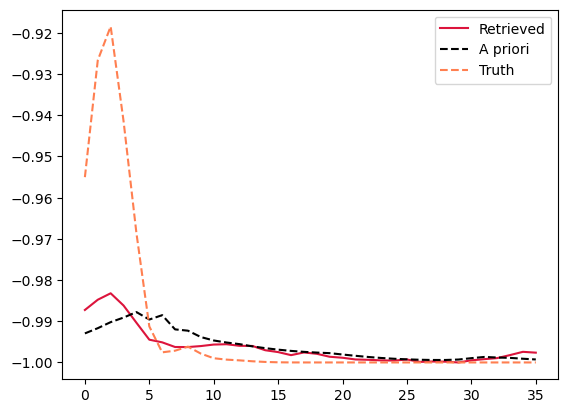

In [153]:
profile = 3
start = 36 * profile
end = start + 36
plt.plot(x_n.cpu().detach()[0, start:end], c="crimson", label="Retrieved")
plt.plot(nlayer(x_a[None]).cpu().detach()[0, start:end], c="k", ls="--", label="A priori")
plt.plot(nlayer(profile_true).detach()[0, start:end], ls="--", c="coral", label="Truth")
plt.legend()

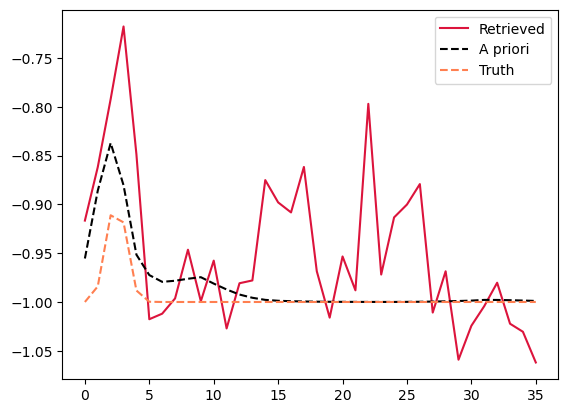

In [141]:
profile = 1
start = 36 * profile
end = start + 36
plt.plot(x_n.cpu().detach()[0, start:end], c="crimson", label="Retrieved")
plt.plot(nlayer(x_a[None]).cpu().detach()[0, start:end], c="k", ls="--", label="A priori")
plt.plot(nlayer(profile_true).detach()[0, start:end], ls="--", c="coral", label="Truth")
plt.legend()

In [120]:
model.stems["input"][1].kind

AttributeError: 'MLPStem' object has no attribute 'kind'

In [400]:
x, y = test_dataset[0]

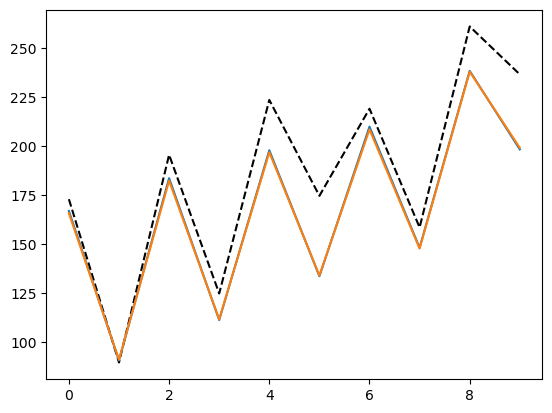

In [157]:
plt.plot(y_a[0].cpu().detach(), c="k", ls="--", label="y_0")
plt.plot(y_step[0].cpu().detach(), label="Retrieved")
plt.plot(y_true[0].cpu().detach(), label="True")

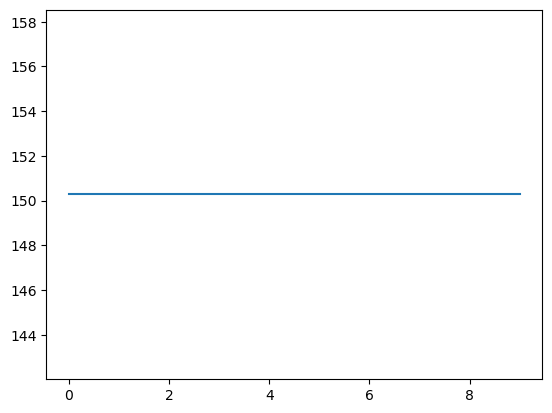

In [816]:
plt.plot(y_step[0].cpu().detach())

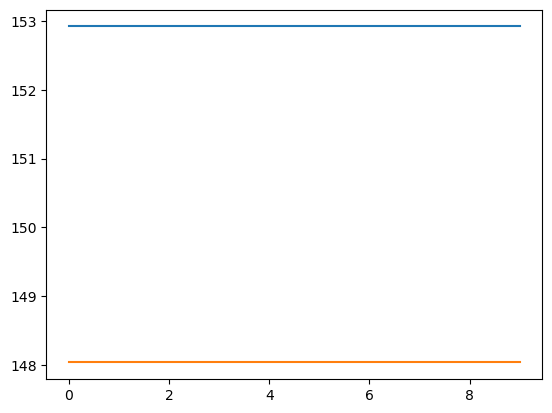

In [814]:
plt.plot(y_true.cpu().numpy()[0])
plt.plot(y_mod.cpu().numpy()[0])

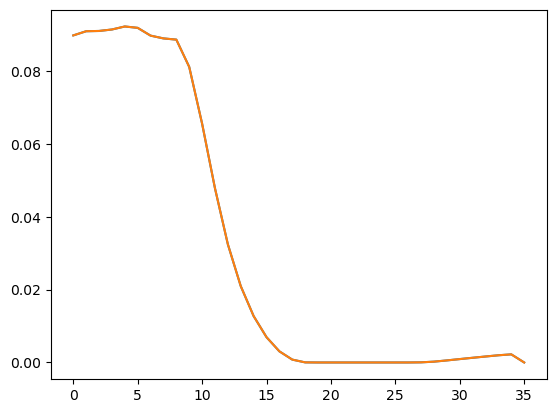

In [122]:
plt.plot(profile_true[0, 3 * 36 : 4 * 36])
plt.plot(profile_mod[0, 3 * 36 : 4 * 36])

In [162]:
x, y = test_dataset[0]

In [68]:
y_true

array([[144.9316]], dtype=float32)